## Check diffusion

In [1]:
import os
import cv2
from skimage import metrics
import csv
import numpy as np
from torchvision import transforms
from PIL import Image
from torchmetrics.image import VisualInformationFidelity, UniversalImageQualityIndex, MultiScaleStructuralSimilarityIndexMeasure

# Function to load and preprocess an image
def load_image(image_path):

    # Define the image size for resizing
    image_size = 512

    # Define the transformation
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor()
    ])

    image = Image.open(image_path).convert('RGB')  # Ensure image is RGB
    image = transform(image)  # Apply the transformations
    return image

def get_metrics(path_original, path_transformed):
    # Load and preprocess the images
    original = load_image(path_original)
    transformed = load_image(path_transformed)

    # Add a batch dimension
    original = original.unsqueeze(0)  # Adds a batch dimension at position 0
    transformed = transformed.unsqueeze(0)  # Adds a batch dimension at position 0

    # Instantiate the VIF metric
    vif = VisualInformationFidelity()

    # Compute the VIF
    vif_value = vif(transformed, original)

    uqi = UniversalImageQualityIndex()

    # Compute the UIQI
    uqi_value = uqi(transformed, original)

    ms_ssim = MultiScaleStructuralSimilarityIndexMeasure(data_range=1.0)
    ms_ssim_value =  ms_ssim(transformed, original)

    return vif_value.item(), uqi_value.item(), ms_ssim_value.item()

def get_all_png_from_folder(f):
    all_images = []
    for images in os.listdir(f):
    
        # check if the image ends with png
        if (images.endswith(".png")):
            all_images.append(images)
    return all_images

def save_to_csv(csv_fn, csv_header, res_list):
    with open(csv_fn, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(csv_header)
        writer.writerows(res_list)
    return


# Set the input/output folders
main_path = 'D:/'
input_path = main_path + 'Datasets/masks_for_inpainting_check_resized/'
all_folders = os.listdir(input_path)
res_folder = main_path + 'Experiments/Results/Diffusion-check/'
path_csv = main_path + 'Experiments/Results/'

# Define the headers for the CSV files
csv_header = ['Model', 'Folder', 'File_name', 'File_name_version', 'MSE', 'PSNR', 'SSIM', 'VIF', 'UIQI', 'MS-SSIM']
csv_header_mean = ['Model', 'Folder', 'File_name', 'MSE', 'PSNR', 'SSIM', 'VIF', 'UIQI', 'MS-SSIM']

# Initialize lists to store the results
all_res = []
all_res_mean = []

# Loop through all folders in the input path
for folder in all_folders:    
    current_in_folder = input_path + folder + '/'
    current_res_folder = res_folder + folder + '/'
    all_file_folders = os.listdir(current_res_folder)

    # Loop through all file folders in the current results folder
    for file_folder in all_file_folders:        
        original = cv2.imread(current_in_folder + file_folder + '.png')
        all_fn_versions = get_all_png_from_folder(current_res_folder + file_folder)

        # Initialize lists to store the metrics for each version of the file
        mean_MSE = []
        mean_PSNR = []
        mean_SSIM = []
        mean_VIF = []
        mean_UQI = []
        mean_MS_SSIM = []
        for fn_version in all_fn_versions:            
            inpainted = cv2.imread(current_res_folder + file_folder + '/' + fn_version)
            mse1 = metrics.mean_squared_error(original, inpainted)
            psnr = metrics.peak_signal_noise_ratio(original, inpainted)
            original_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY) 
            inpainted_gray = cv2.cvtColor(inpainted, cv2.COLOR_BGR2GRAY) 
            ssim = metrics.structural_similarity(original_gray, inpainted_gray)
            vif, uqi, ms_ssim = get_metrics(current_in_folder + file_folder + '.png', current_res_folder + file_folder + '/' + fn_version)

            # Append the metrics to the respective lists
            mean_MSE.append(mse1)
            mean_PSNR.append(psnr)
            mean_SSIM.append(ssim)
            mean_VIF.append(vif)
            mean_UQI.append(uqi)
            mean_MS_SSIM.append(ms_ssim)

            # Create a row for the current file version
            current_row = ['Diffusion', folder, file_folder, fn_version, mse1, psnr, ssim, vif, uqi, ms_ssim]
            all_res.append(current_row)
        # Create a row for the mean metrics of the current file
        current_row_mean = ['Diffusion', folder, file_folder, np.mean(mean_MSE), np.mean(mean_PSNR), np.mean(mean_SSIM), 
                            np.mean(mean_VIF), np.mean(mean_UQI), np.mean(mean_MS_SSIM)]
        all_res_mean.append(current_row)
        
# Save the results to CSV files        
save_to_csv(path_csv + 'inpainting_quality_check_2024.csv', csv_header, all_res)
save_to_csv(path_csv + 'inpainting_mean_quality_check_2024.csv', csv_header_mean, all_res_mean)

# Check Lama

In [2]:
import os
import cv2
from sys import platform
from skimage import metrics
import csv
import numpy as np

def get_all_png_from_folder(f):
    all_images = []
    for images in os.listdir(f):
    
        # check if the image ends with png
        if (images.endswith(".png")):
            all_images.append(images)
    return all_images

# Function to append results to a CSV file
def save_to_csv(csv_fn, csv_header, res_list):
    with open(csv_fn, 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(csv_header)
        writer.writerows(res_list)
    return

# Define input and output paths
main_path = 'D:/'

input_path = main_path + 'Datasets/masks_for_inpainting_check_resized/'
all_folders = os.listdir(input_path)
res_folder = main_path + 'Experiments/Lama-check/'
path_csv = main_path + 'Experiments/Results/'

# Define the CSV header
csv_header = ['Model', 'Folder', 'File_name', 'File_name_version', 'MSE', 'PSNR', 'SSIM', 'VIF', 'UIQI', 'MS-SSIM']
all_res = []

# Loop through all folders in the input path
for folder in all_folders:    
    current_in_folder = input_path + folder + '/'
    current_res_folder = res_folder + folder + '/'

    # Get all PNG files from the current results folder
    all_files = get_all_png_from_folder(current_res_folder)

    # Loop through all files in the current results folder
    for fn in all_files:   
        # Load the original and inpainted images     
        original = cv2.imread(current_in_folder + fn[:-9] + '.png')
        inpainted = cv2.imread(current_res_folder + fn)    

        # Calculate MSE and PSNR
        mse1 = metrics.mean_squared_error(original, inpainted)
        psnr = metrics.peak_signal_noise_ratio(original, inpainted)

        # Convert images to grayscale for SSIM calculation
        original_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY) 
        inpainted_gray = cv2.cvtColor(inpainted, cv2.COLOR_BGR2GRAY) 
        ssim = metrics.structural_similarity(original_gray, inpainted_gray)

        # Calculate additional metrics using the get_metrics function
        vif, uqi, ms_ssim = get_metrics(current_in_folder + fn[:-9] + '.png', current_res_folder + fn)

        # Create a row with all the metrics
        current_row = ['Lama', folder, fn[:-9], fn, mse1, psnr, ssim, vif, uqi, ms_ssim]

        # Append the row to the results list
        all_res.append(current_row)

# Save the results to a CSV file
save_to_csv(path_csv + 'inpainting_mean_quality_2024.csv', csv_header, all_res)

# Check the mean values

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

main_path = 'D:/'


input_path = main_path + 'Datasets/masks_for_inpainting_check_resized/'
all_folders = os.listdir(input_path)
res_folder = main_path + 'Experiments/Lama-check/'
path_csv = main_path + 'Experiments/Results/'

df = pd.read_csv(path_csv + 'inpainting_mean_quality_check_2024.csv', header=0)

df

Model         Folder    File_name               File_name_version  \
0    Diffusion  Large-margins  frame_00084  frame_00084__v_9__sec_2.80.png   
1    Diffusion  Large-margins  frame_00085  frame_00085__v_9__sec_2.80.png   
2    Diffusion  Large-margins  frame_00086  frame_00086__v_9__sec_2.79.png   
3    Diffusion  Large-margins  frame_00087  frame_00087__v_9__sec_2.79.png   
4    Diffusion  Large-margins  frame_00088  frame_00088__v_9__sec_2.79.png   
..         ...            ...          ...                             ...   
227       Lama      Rectangle  frame_00112            frame_00112_mask.png   
228       Lama      Rectangle  frame_00113            frame_00113_mask.png   
229       Lama      Rectangle  frame_00114            frame_00114_mask.png   
230       Lama      Rectangle  frame_00132            frame_00132_mask.png   
231       Lama      Rectangle  frame_00133            frame_00133_mask.png   

            MSE       PSNR      SSIM       VIF      UIQI   MS-SSIM  
0     98.443223  28.198945  0.856575  0.875738  0.293219  0.963849  
1     94.797393  28.362840  0.846968  0.869140  0.295875  0.964813  
2     98.708093  28.187276  0.845330  0.869679  0.294724  0.966791  
3    101.129634  28.082019  0.846347  0.857992  0.294971  0.966770  
4    101.576251  28.062882  0.851034  0.856816  0.291470  0.967365  
..          ...        ...       ...       ...       ...       ...  
227    0.295086  53.431319  0.998019  0.999737  0.535119  0.999149  
228    1.673125  45.895520  0.995924  0.997470  0.558007  0.998634  
229    0.419209  51.906503  0.996932  0.999451  0.533267  0.998808  
230    0.943834  48.381849  0.996200  0.998220  0.575725  0.998970  
231    0.868619  48.742509  0.994889  0.998636  0.569045  0.998552  

[232 rows x 10 columns]

In [10]:
df.describe()

MSE        PSNR        SSIM         VIF        UIQI     MS-SSIM
count  232.000000  232.000000  232.000000  232.000000  232.000000  232.000000
mean    47.483858   35.561805    0.932041    0.934375    0.423433    0.983961
std     42.528601    7.602506    0.063863    0.062581    0.117427    0.013778
min      0.295086   27.592611    0.841905    0.844399    0.279146    0.963048
25%      3.848242   28.582473    0.864366    0.869640    0.295401    0.970196
50%     46.552750   31.948787    0.947236    0.984844    0.431578    0.984745
75%     90.123107   42.278215    0.994670    0.995250    0.535617    0.998046
max    113.192916   53.431319    0.998901    0.999737    0.577263    0.999677

In [11]:
df.groupby(['Model', 'Folder'], as_index=False)['MSE', 'PSNR', 'SSIM', 'VIF', 'UIQI', 'MS-SSIM'].mean()


C:\Users\scata\AppData\Local\Temp/ipykernel_2672/1522018650.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby(['Model', 'Folder'], as_index=False)['MSE', 'PSNR', 'SSIM', 'VIF', 'UIQI', 'MS-SSIM'].mean()


Model              Folder        MSE       PSNR      SSIM       VIF  \
0  Diffusion       Large-margins  95.559603  28.357739  0.869415  0.869334   
1  Diffusion             Margins  88.164526  28.697445  0.872955  0.874537   
2  Diffusion  Margins-and-center  88.076673  28.705240  0.866674  0.877859   
3  Diffusion           Rectangle  84.896015  28.860480  0.870209  0.876644   
4       Lama       Large-margins  12.996416  37.271185  0.992249  0.989431   
5       Lama             Margins   3.558286  43.197278  0.997560  0.995206   
6       Lama  Margins-and-center   5.331023  41.523271  0.991912  0.993941   
7       Lama           Rectangle   1.288322  47.881803  0.995355  0.998047   

       UIQI   MS-SSIM  
0  0.307930  0.969264  
1  0.309557  0.971486  
2  0.305606  0.969950  
3  0.309613  0.971032  
4  0.538154  0.995623  
5  0.545089  0.999044  
6  0.532477  0.997072  
7  0.539037  0.998219

In [13]:
print(df.groupby(['Model', 'Folder'], as_index=False)['MSE', 'PSNR', 'SSIM', 'VIF', 'UIQI', 'MS-SSIM'].mean().to_latex(index=False, #
                  formatters={"name": str.upper},
                  float_format="{:.3f}".format,
))

\begin{tabular}{llrrrrrr}
\toprule
    Model &             Folder &    MSE &   PSNR &  SSIM &   VIF &  UIQI &  MS-SSIM \\
\midrule
Diffusion &      Large-margins & 95.560 & 28.358 & 0.869 & 0.869 & 0.308 &    0.969 \\
Diffusion &            Margins & 88.165 & 28.697 & 0.873 & 0.875 & 0.310 &    0.971 \\
Diffusion & Margins-and-center & 88.077 & 28.705 & 0.867 & 0.878 & 0.306 &    0.970 \\
Diffusion &          Rectangle & 84.896 & 28.860 & 0.870 & 0.877 & 0.310 &    0.971 \\
     Lama &      Large-margins & 12.996 & 37.271 & 0.992 & 0.989 & 0.538 &    0.996 \\
     Lama &            Margins &  3.558 & 43.197 & 0.998 & 0.995 & 0.545 &    0.999 \\
     Lama & Margins-and-center &  5.331 & 41.523 & 0.992 & 0.994 & 0.532 &    0.997 \\
     Lama &          Rectangle &  1.288 & 47.882 & 0.995 & 0.998 & 0.539 &    0.998 \\
\bottomrule
\end{tabular}



C:\Users\scata\AppData\Local\Temp/ipykernel_2672/369647468.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  print(df.groupby(['Model', 'Folder'], as_index=False)['MSE', 'PSNR', 'SSIM', 'VIF', 'UIQI', 'MS-SSIM'].mean().to_latex(index=False, #


In [14]:
df.groupby(['Model'], as_index=False)['MSE', 'PSNR', 'SSIM', 'VIF', 'UIQI', 'MS-SSIM'].mean()

C:\Users\scata\AppData\Local\Temp/ipykernel_2672/2666959731.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby(['Model'], as_index=False)['MSE', 'PSNR', 'SSIM', 'VIF', 'UIQI', 'MS-SSIM'].mean()


Model        MSE       PSNR      SSIM       VIF      UIQI   MS-SSIM
0  Diffusion  89.174204  28.655226  0.869813  0.874593  0.308176  0.970433
1       Lama   5.793512  42.468385  0.994269  0.994156  0.538689  0.997490

# Check diffusion differences for the same image

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

main_path = 'D:/'


path_csv = main_path + 'Experiments/Results/'

df = pd.read_csv(path_csv + 'inpainting_quality_check_2024.csv', header=0)

df

Model         Folder    File_name               File_name_version  \
0     Diffusion  Large-margins  frame_00084  frame_00084__v_0__sec_2.80.png   
1     Diffusion  Large-margins  frame_00084  frame_00084__v_1__sec_2.80.png   
2     Diffusion  Large-margins  frame_00084  frame_00084__v_2__sec_2.80.png   
3     Diffusion  Large-margins  frame_00084  frame_00084__v_3__sec_2.80.png   
4     Diffusion  Large-margins  frame_00084  frame_00084__v_4__sec_2.80.png   
...         ...            ...          ...                             ...   
1155  Diffusion      Rectangle  frame_00133  frame_00133__v_5__sec_2.79.png   
1156  Diffusion      Rectangle  frame_00133  frame_00133__v_6__sec_2.79.png   
1157  Diffusion      Rectangle  frame_00133  frame_00133__v_7__sec_2.79.png   
1158  Diffusion      Rectangle  frame_00133  frame_00133__v_8__sec_2.79.png   
1159  Diffusion      Rectangle  frame_00133  frame_00133__v_9__sec_2.79.png   

             MSE       PSNR      SSIM       VIF      UIQI   MS-SSIM  
0     103.753380  27.970781  0.842951  0.872380  0.289447  0.961858  
1      85.499107  28.811188  0.891323  0.851216  0.302466  0.967146  
2     108.698045  27.768586  0.851693  0.863577  0.294613  0.962176  
3      86.721497  28.749536  0.881568  0.866950  0.298627  0.966656  
4     103.441224  27.983867  0.841527  0.860272  0.291814  0.963213  
...          ...        ...       ...       ...       ...       ...  
1155   74.508559  29.408742  0.875470  0.872274  0.347468  0.973637  
1156   77.378919  29.244577  0.866303  0.858615  0.342664  0.972006  
1157   67.753789  29.821468  0.916531  0.875850  0.358313  0.976058  
1158   77.851215  29.218150  0.874961  0.867188  0.341020  0.970868  
1159   78.303347  29.193000  0.877141  0.880669  0.347837  0.972913  

[1160 rows x 10 columns]

In [3]:
df_grouped = df.groupby(['Folder', 'File_name'], as_index=False)['MSE', 'PSNR', 'SSIM', 'VIF', 'UIQI', 'MS-SSIM'].mean()

# Calculate the distinct values from the "File_name" column
distinct_values = df_grouped['File_name'].unique()

# Create a dictionary to map distinct values to the desired numeric values
mapping = {value: index + 1 for index, value in enumerate(distinct_values)}

# Add a new column named "ID" to the dataframe, mapping 'File_name' to the numeric values
df_grouped['ID'] = df_grouped['File_name'].map(mapping)
df_grouped

C:\Users\scata\AppData\Local\Temp/ipykernel_33064/692263542.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_grouped = df.groupby(['Folder', 'File_name'], as_index=False)['MSE', 'PSNR', 'SSIM', 'VIF', 'UIQI', 'MS-SSIM'].mean()


Folder    File_name         MSE       PSNR      SSIM       VIF  \
0    Large-margins  frame_00084   97.851308  28.247346  0.861314  0.864229   
1    Large-margins  frame_00085   90.323000  28.585121  0.858932  0.862894   
2    Large-margins  frame_00086  100.971859  28.110640  0.854843  0.870201   
3    Large-margins  frame_00087  101.191534  28.097481  0.861416  0.853413   
4    Large-margins  frame_00088  105.976166  27.893453  0.863596  0.851159   
..             ...          ...         ...        ...       ...       ...   
111      Rectangle  frame_00112   71.588322  29.594076  0.905691  0.883806   
112      Rectangle  frame_00113   76.636885  29.301834  0.898362  0.892725   
113      Rectangle  frame_00114   67.326728  29.857649  0.909997  0.876351   
114      Rectangle  frame_00132   77.665102  29.235183  0.888564  0.864471   
115      Rectangle  frame_00133   75.050697  29.385283  0.882853  0.869192   

         UIQI   MS-SSIM  ID  
0    0.294991  0.963944   1  
1    0.296863  0.966511   2  
2    0.293901  0.966302   3  
3    0.295029  0.966119   4  
4    0.293366  0.965971   5  
..        ...       ...  ..  
111  0.345817  0.976186  25  
112  0.347948  0.975484  26  
113  0.357391  0.977313  27  
114  0.350364  0.973975  28  
115  0.348010  0.973181  29  

[116 rows x 9 columns]

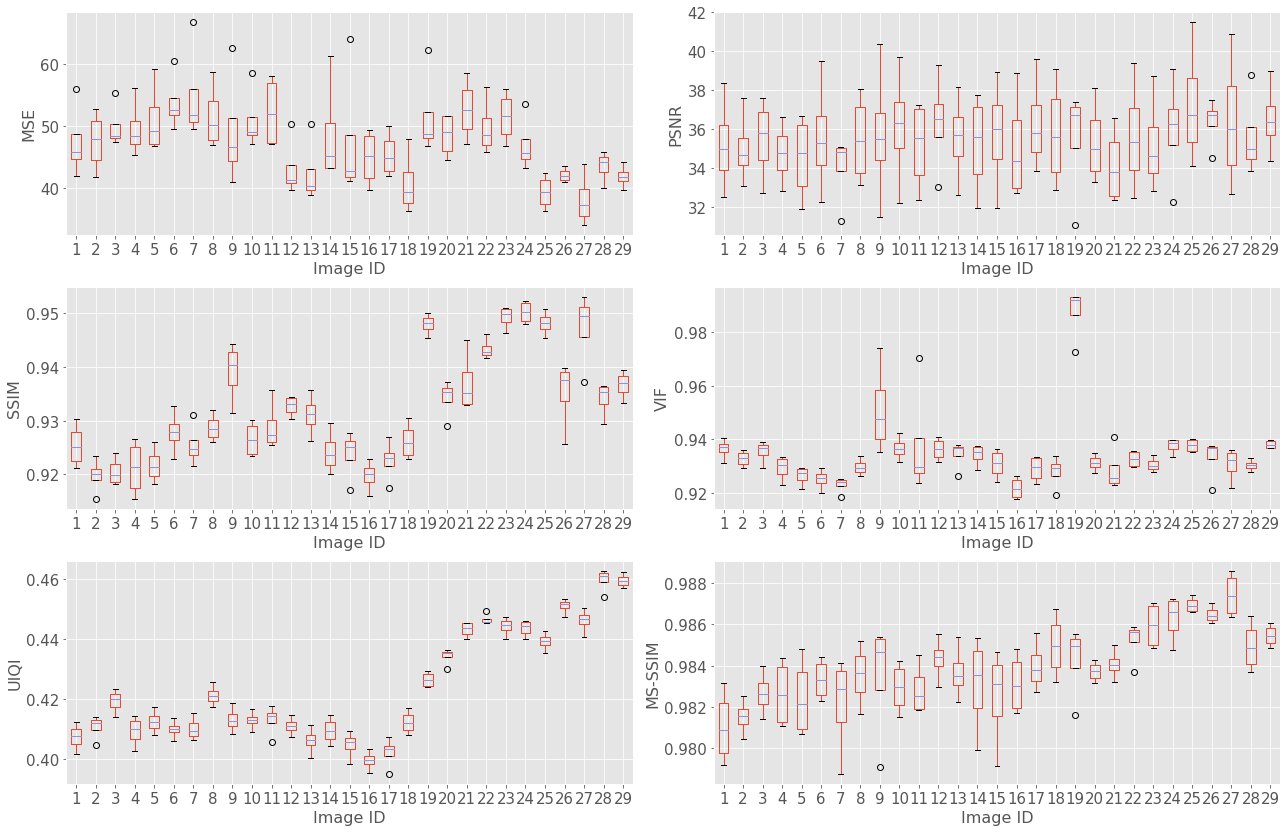

In [19]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
fig, axes = plt.subplots(3,2) # create figure and axes
fig.set_figheight(12)
fig.set_figwidth(18)

# Define the labels for the y-axis
y_labels = ['MSE', 'PSNR', 'SSIM', 'VIF', 'UIQI', 'MS-SSIM']
for i,el in enumerate(list(df_grouped.columns.values)[2:-1]):
    a = df_grouped.boxplot(el, by="ID", ax=axes.flatten()[i], fontsize=15)
    a.set_ylabel(y_labels[i],fontdict={'fontsize':16})
    a.set_xlabel('Image ID', fontdict={'fontsize':16})
    a.set_title('')

plt.tight_layout() 
plt.suptitle("")
plt.show()
fig.savefig('D:/differences_diffusion.pdf')

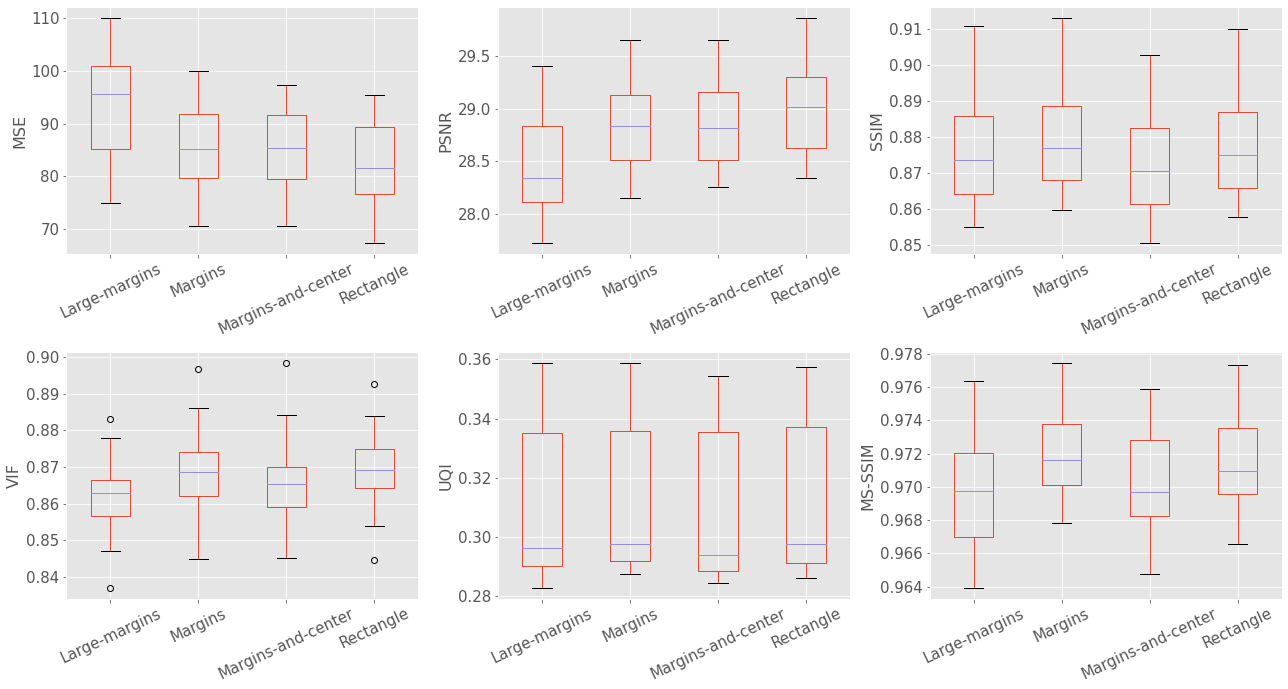

In [17]:
plt.style.use('ggplot')
fig, axes = plt.subplots(2,3) # create figure and axes
fig.set_figheight(10)
fig.set_figwidth(18)
y_labels = ['MSE', 'PSNR', 'SSIM', 'VIF', 'UQI', 'MS-SSIM']
for i,el in enumerate(list(df_grouped.columns.values)[2:-1]):
    a = df_grouped.boxplot(el, by="Folder", ax=axes.flatten()[i], fontsize=15, rot = 25)
    
    a.set_ylabel(y_labels[i],fontdict={'fontsize':16})
    a.set_xlabel('')
    a.set_title('')

plt.tight_layout() 
plt.suptitle("")
plt.show()

In [18]:
df_grouped.groupby('Folder').mean()

MSE       PSNR      SSIM       VIF       UQI  \
Folder                                                                   
Large-margins       93.201225  28.476776  0.876426  0.861575  0.309192   
Margins             85.996882  28.816463  0.880262  0.868585  0.310896   
Margins-and-center  85.369500  28.845635  0.873668  0.865936  0.307376   
Rectangle           82.578275  28.991000  0.877989  0.869222  0.310832   

                     MS-SSIM    ID  
Folder                              
Large-margins       0.969625  15.0  
Margins             0.971911  15.0  
Margins-and-center  0.970429  15.0  
Rectangle           0.971527  15.0

# Check precise values

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import os

main_path = 'D:/'

input_path = main_path + 'Datasets/masks_for_inpainting_check_resized/'
all_folders = os.listdir(input_path)
res_folder = main_path + 'Experiments/Diffusion-check/'
path_csv = main_path + 'Experiments/Results/'

df = pd.read_csv(path_csv + 'inpainting_quality_check_2024.csv', header=0)

# Check results for a certain file
fn = 'frame_00132__v_5__sec_2.79.png'
df.loc[df['File_name_version'] == fn]

Model   Folder    File_name               File_name_version  \
565  Diffusion  Margins  frame_00132  frame_00132__v_5__sec_2.79.png   

           MSE       PSNR      SSIM       VIF      UIQI  MS-SSIM  
565  77.868458  29.217188  0.888044  0.868612  0.351456   0.9744

# Create image comparison

## Common part

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

import os

def crop_image(input_image):

    new_h = 288
    current_h = 512

    starting_point = (int)((current_h - new_h) / 2)
    return input_image[starting_point:starting_point + new_h, ]

main_path = 'D:/'


input_path = main_path + 'Datasets/masks_for_inpainting_check_resized/'
all_folders = os.listdir(input_path)
diff_folder = main_path + 'Experiments/Diffusion-check/'
lama_folder = main_path + 'Experiments/Lama-check/'
output_path = 'D:/images-2024/'
path_csv = main_path + 'Experiments/Results/'


## LaMa

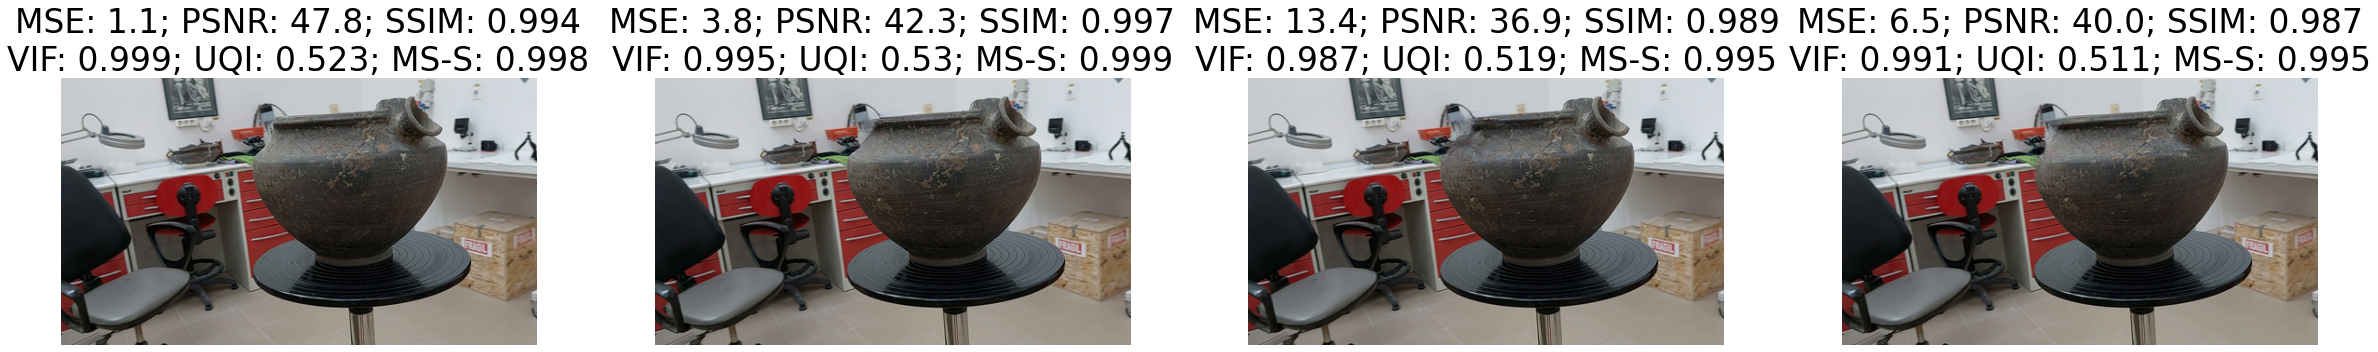

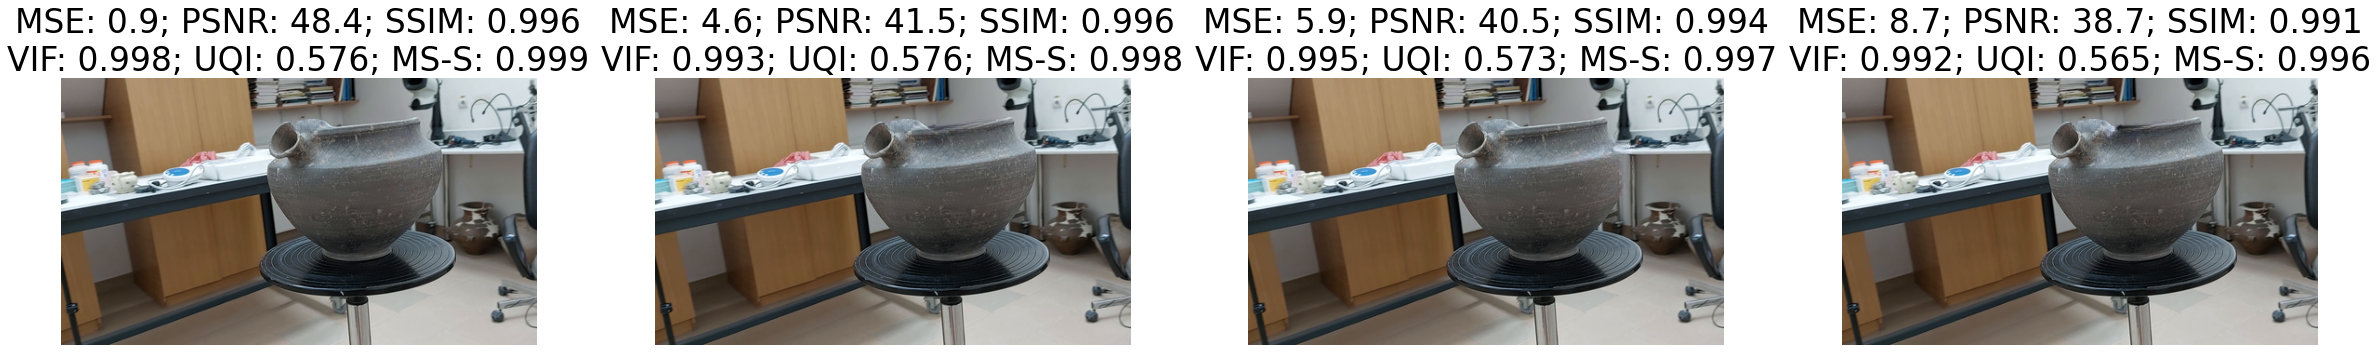

In [19]:


def get_outputs(folder):
    decimals = 1
    return round(df.loc[(df['File_name'] == pic_fn) & (df['Model'] == 'Lama') & (df['Folder'] == folder), 'MSE'].values[0], decimals), \
            round(df.loc[(df['File_name'] == pic_fn) & (df['Model'] == 'Lama') & (df['Folder'] == folder), 'PSNR'].values[0], decimals), \
            round(df.loc[(df['File_name'] == pic_fn) & (df['Model'] == 'Lama') & (df['Folder'] == folder), 'SSIM'].values[0], decimals + 2), \
            round(df.loc[(df['File_name'] == pic_fn) & (df['Model'] == 'Lama') & (df['Folder'] == folder), 'VIF'].values[0], decimals + 2), \
            round(df.loc[(df['File_name'] == pic_fn) & (df['Model'] == 'Lama') & (df['Folder'] == folder), 'UIQI'].values[0], decimals + 2), \
            round(df.loc[(df['File_name'] == pic_fn) & (df['Model'] == 'Lama') & (df['Folder'] == folder), 'MS-SSIM'].values[0], decimals + 2)

file_names = ['frame_00084', 'frame_00132']

pic_fn = 'frame_00084' #frame_00132
current_model = 'Lama'

font_size = 33

df = pd.read_csv(path_csv + 'inpainting_mean_quality_2024.csv', header=0)

for pic_fn in file_names:
    fig = plt.figure(figsize=(34, 5))

    id_masks = 1
    for fd in ['Rectangle', 'Margins', 'Large-margins', 'Margins-and-center']:
        # Read the first image in the folder
        image_path = os.path.join(lama_folder + fd, pic_fn + '_mask.png')
        #print(image_path)
        image = crop_image(plt.imread(image_path))
        mse, psnr, ssim, vif, uqi, ms_ssim = get_outputs(fd)
        plt.subplot(1, 4, id_masks)
        title = 'MSE: ' + str(mse) + '; PSNR: ' + str(psnr) + '; SSIM: ' + str(ssim) + '\nVIF: ' + str(vif) + '; UQI: ' + str(uqi) + '; MS-S: ' + str(ms_ssim)
        plt.title(title, fontsize = font_size)
        plt.axis("off")
        # Plot the image
        plt.tight_layout()
        
        id_masks += 1
        plt.imshow(image)
    plt.savefig(output_path + current_model + '_' + pic_fn + '_masks.pdf')


## Diffusion

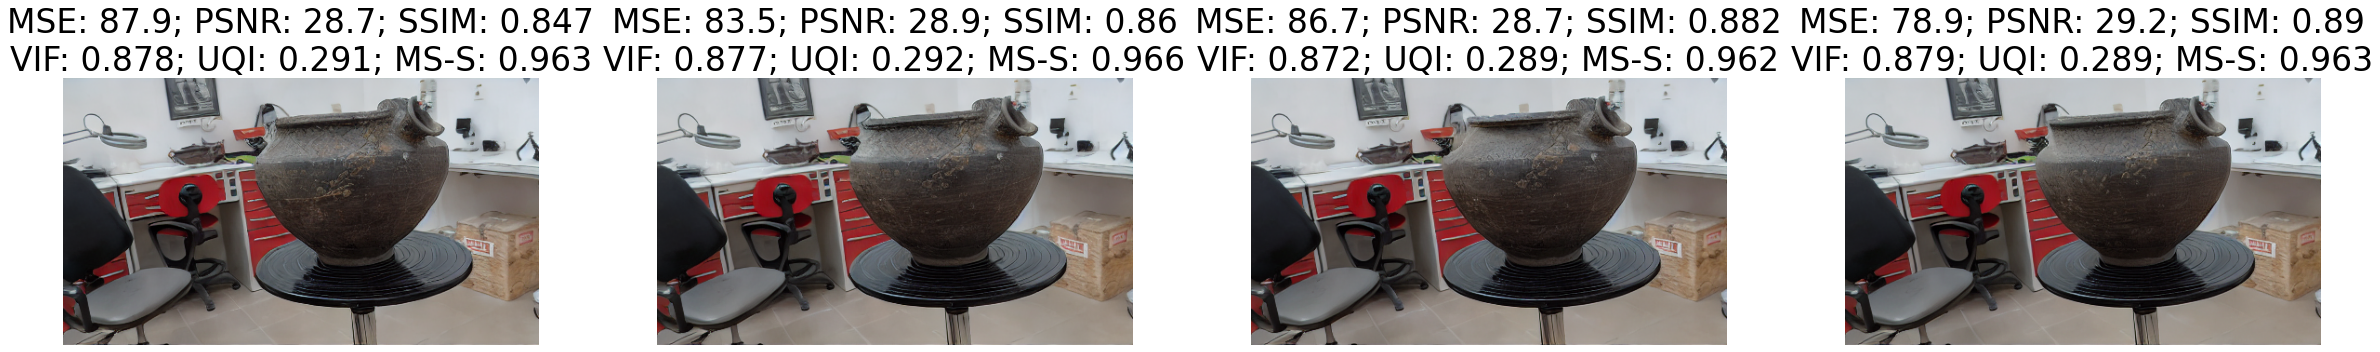

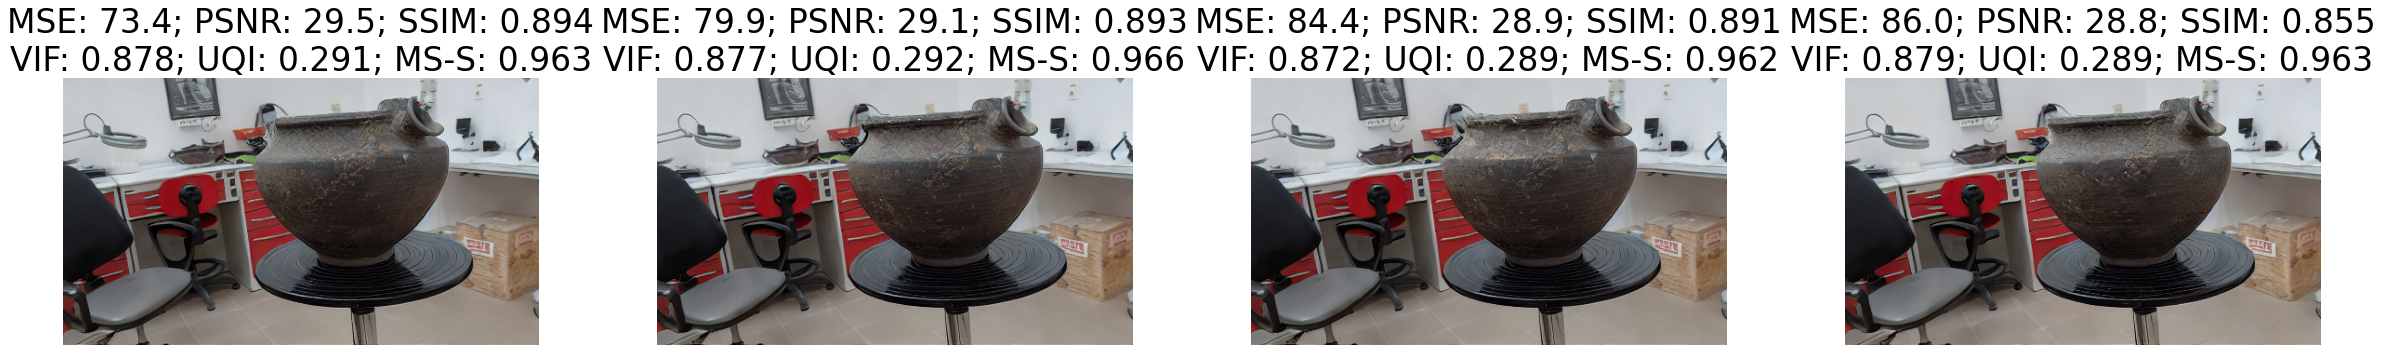

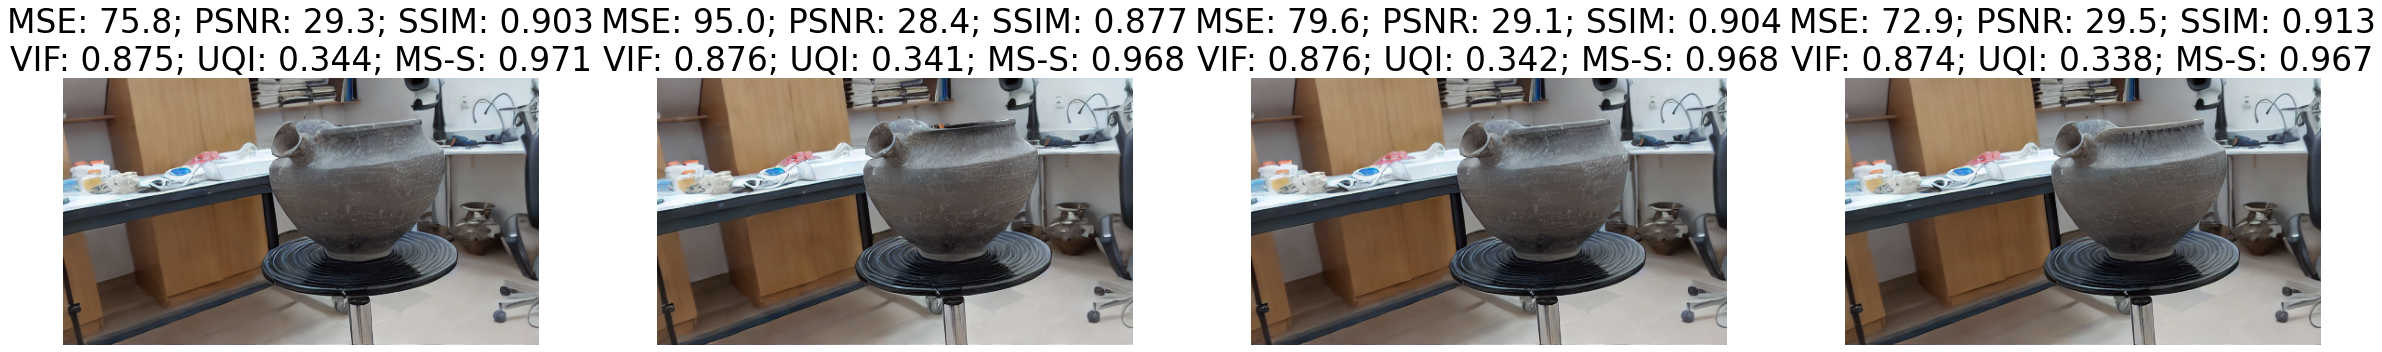

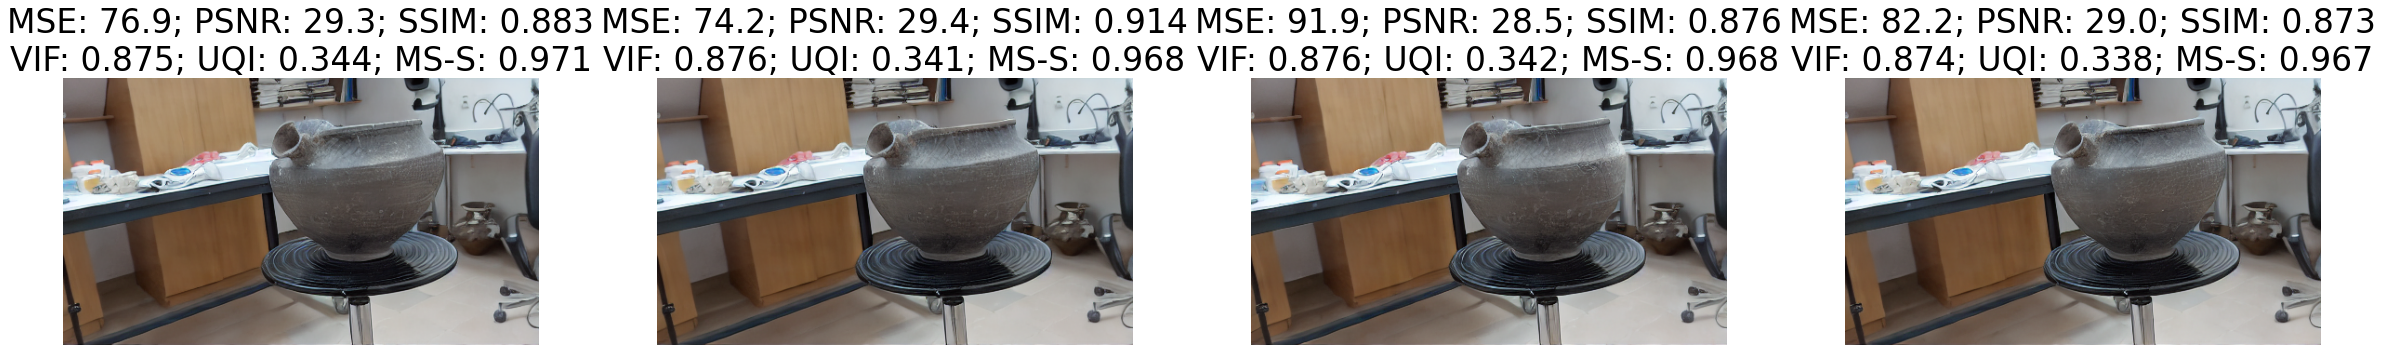

In [22]:
def get_outputs(folder, version):
    decimals = 1
    
    return round(df.loc[(df['File_name'] == pic_fn) & (df['Model'] == 'Diffusion') & (df['Folder'] == folder)  & (df['version'] == str(version)), 'MSE'].values[0], decimals), \
            round(df.loc[(df['File_name'] == pic_fn) & (df['Model'] == 'Diffusion') & (df['Folder'] == folder) & (df['version'] == str(version)), 'PSNR'].values[0], decimals), \
            round(df.loc[(df['File_name'] == pic_fn) & (df['Model'] == 'Diffusion') & (df['Folder'] == folder)  & (df['version'] == str(version)), 'SSIM'].values[0], decimals + 2), \
            round(df.loc[(df['File_name'] == pic_fn) & (df['Model'] == 'Diffusion') & (df['Folder'] == folder), 'VIF'].values[0], decimals + 2), \
            round(df.loc[(df['File_name'] == pic_fn) & (df['Model'] == 'Diffusion') & (df['Folder'] == folder), 'UQI'].values[0], decimals + 2), \
            round(df.loc[(df['File_name'] == pic_fn) & (df['Model'] == 'Diffusion') & (df['Folder'] == folder), 'MS-SSIM'].values[0], decimals + 2)

def create_dict_diffusion():

    pic_fn_values = ['frame_00084', 'frame_00132']

    # Create a dictionary to store the folder values for each pic_fn
    data_dict = {}

    for pic_fn in pic_fn_values:
        if pic_fn == 'frame_00084':
            numerical_values = [(0, 1), (2, 7), (3, 7), (1, 9)]
        elif pic_fn == 'frame_00132':
            numerical_values = [(3, 5), (0, 1), (3, 0), (1, 2)]

        # Create a dictionary for the current pic_fn
        pic_fn_data = {}
        for i, folder in enumerate(['Rectangle', 'Margins', 'Large-margins', 'Margins-and-center']):
            pic_fn_data[folder] = numerical_values[i]

        # Add the pic_fn_data to the main data_dict
        data_dict[pic_fn] = pic_fn_data
    return data_dict

def get_fn_version_diffusion(current_folder, version):
    searched_fn = [s for s in os.listdir(current_folder) if s.startswith(pic_fn + '__v_' + str(version))]
    return searched_fn[0]

diffusion_dict = create_dict_diffusion()

#print(diffusion_dict['frame_00084']['Rectangle'])

file_names = ['frame_00084', 'frame_00132']

pic_fn = 'frame_00084' # 'frame_00132'
current_model = 'Diffusion'
df = pd.read_csv(path_csv + 'inpainting_quality_check_2024.csv', header=0)
df['version'] = df.File_name_version.str[15:16]

for pic_fn in file_names:
    
    for diffusion_version in [0, 1]:
        fig = plt.figure(figsize=(34, 5))
        id_masks = 1
        for fd in ['Rectangle', 'Margins', 'Large-margins', 'Margins-and-center']:
            # Read the first image in the folder
            version = diffusion_dict[pic_fn][fd][diffusion_version]
            current_folder = diff_folder + fd + '/' + pic_fn + '/'
            current_fn_diffusion = get_fn_version_diffusion(current_folder, version)
            image_path = current_folder + current_fn_diffusion  # os.path.join(diff_folder + fd, pic_fn + '_mask.png')    
            image = crop_image(plt.imread(image_path))    
            mse, psnr, ssim, vif, uqi, ms_ssim = get_outputs(fd, version)    
            plt.subplot(1, 4, id_masks)
            title = 'MSE: ' + str(mse) + '; PSNR: ' + str(psnr) + '; SSIM: ' + str(ssim) + '\nVIF: ' + str(vif) + '; UQI: ' + str(uqi) + '; MS-S: ' + str(ms_ssim)
            plt.title(title, fontsize = font_size)
            plt.axis("off")
            # Plot the image
            plt.tight_layout()
            
            id_masks += 1
            plt.imshow(image)
        plt.savefig(output_path + current_model + '_version' + str(diffusion_version) + '_' + pic_fn + '_masks.pdf')


# Check similarity for an uneffected region

The images have same size and channels
The images are completely Equal


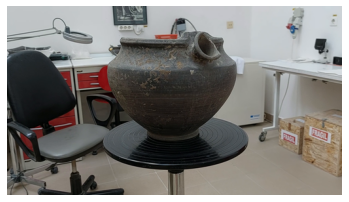

In [6]:
import matplotlib.pyplot as plt
from sys import platform
import os
import cv2

# Function to crop the input image to a height of 288 pixels centered vertically
def crop_image(input_image):
    new_h = 288
    current_h = 512

    starting_point = (int)((current_h - new_h) / 2)
    return input_image[starting_point:starting_point + new_h, ]

# Function to display a cv2 image using matplotlib
def show_cv2_image(im_cv2):
    im_RGB = cv2.cvtColor(im_cv2, cv2.COLOR_BGR2RGB) 
    plt.axis('off')
    plt.imshow(im_RGB) 
  

    plt.show() 

# Function to draw a red rectangle on the image
def draw_rectangle(image, start_point = (355, 115), end_point = (380, 140)):
     
    color = (0, 0, 255) 
    
    thickness = 3
    
    image = cv2.rectangle(image, start_point, end_point, color, thickness)
    return

# Function to get the filename of a specific version of a diffusion result
def get_fn_version_diffusion(current_folder, version = 0):
    searched_fn = [s for s in os.listdir(current_folder) if s.startswith(fn + '__v_' + str(version))]
    return searched_fn[0]

# Function to check if two images are identical
def check_if_identical(original, other):
    if original.shape == other.shape:
        print("The images have same size and channels")
    difference = cv2.subtract(original, other)
    b, g, r = cv2.split(difference)
    if cv2.countNonZero(b) == 0 and cv2.countNonZero(g) == 0 and cv2.countNonZero(r) == 0:
        print("The images are completely Equal")

# Define input and output paths
main_path = 'D:/'

input_path = main_path + 'Datasets/masks_for_inpainting_check_resized/'
all_folders = os.listdir(input_path)
diff_folder = main_path + 'Experiments/Diffusion-check/'
lama_folder = main_path + 'Experiments/Lama-check/'
output_path = 'D:/images-2004/'

diff_folder += 'Rectangle/'
lama_folder += 'Rectangle/'


# Set the filename to be processed
fn = 'frame_00098'

# Crop and read the images for LAMA and diffusion methods
im_lama = crop_image(cv2.imread(lama_folder + fn + '_mask.png'))
im_diffusion = crop_image(cv2.imread(diff_folder + fn + '/' + get_fn_version_diffusion(diff_folder + fn + '/')))

# Define the rectangle coordinates for the region of interest (ROI)
start_point = (15, 115)
end_point = (138, 140)

# Extract the ROI from the LAMA and diffusion images
img_roi_lama = im_lama[start_point[1]:end_point[1],start_point[0]:end_point[0]]
img_roi_diffusion = im_diffusion[start_point[1]:end_point[1],start_point[0]:end_point[0]]

# Crop and read the original image and extract the ROI
im_original = crop_image(cv2.imread(input_path + 'Rectangle/' + fn + '.png'))
img_roi_original = im_original[start_point[1]:end_point[1],start_point[0]:end_point[0]]

# Check if the ROIs of the original and LAMA images are identical
check_if_identical(img_roi_original, img_roi_lama)

# Display the LAMA image
show_cv2_image(im_lama)



c:\Users\scata\anaconda3\lib\site-packages\skimage\metrics\simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


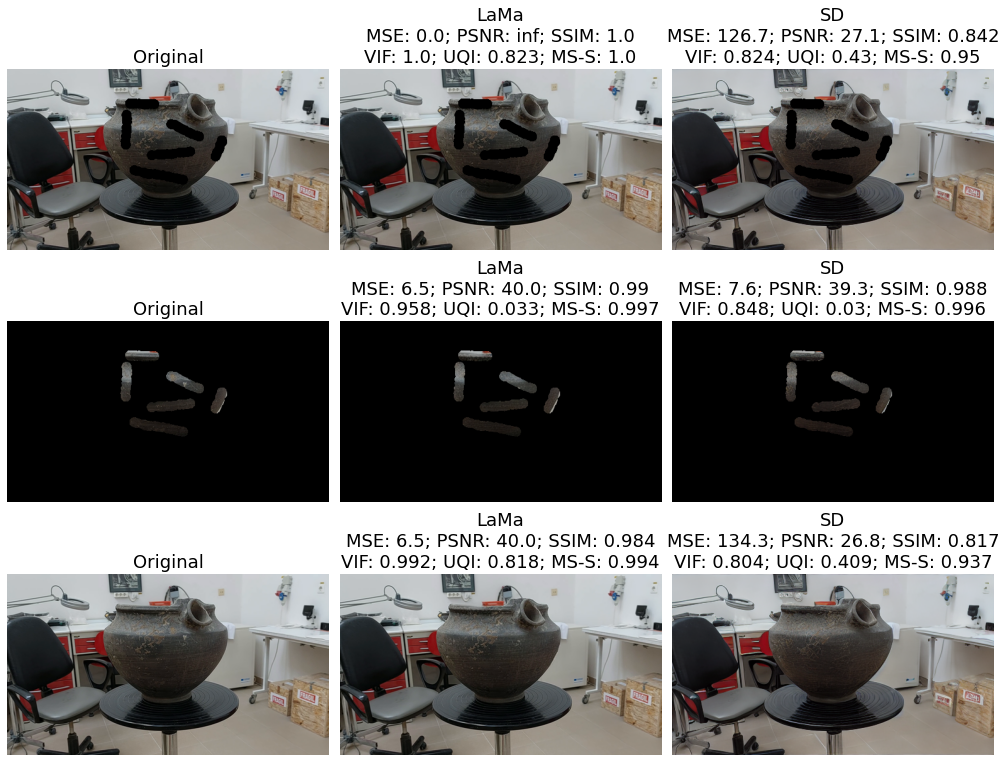

In [7]:
from skimage import metrics
import numpy as np
from torchvision import transforms
from PIL import Image
from torchmetrics.image import VisualInformationFidelity, UniversalImageQualityIndex, MultiScaleStructuralSimilarityIndexMeasure

# Function to transform a CV2 image to a tensor
def transform_image_tensor(image_CV):
    image_pil = Image.fromarray(image_CV)  # Convert to PIL image
    image_size = 512
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor()
    ])
    image_tensor = transform(image_pil)
    
    return image_tensor.unsqueeze(0) # Add a batch dimension

# Function to compute various image quality metrics
def compute_metrics(original, inpainted):
    mse1 = metrics.mean_squared_error(original, inpainted)
    psnr = metrics.peak_signal_noise_ratio(original, inpainted)
    original_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY) 
    inpainted_gray = cv2.cvtColor(inpainted, cv2.COLOR_BGR2GRAY) 
    ssim = metrics.structural_similarity(original_gray, inpainted_gray)

    tensor_original = transform_image_tensor(original)
    tensor_inpainted = transform_image_tensor(inpainted)

    # Instantiate the VIF metric
    vif = VisualInformationFidelity()

    # Compute the VIF
    vif_value = vif(tensor_inpainted, tensor_original)

    uqi = UniversalImageQualityIndex()

    # Compute the UQI
    uqi_value = uqi(tensor_inpainted, tensor_original)

    ms_ssim = MultiScaleStructuralSimilarityIndexMeasure(data_range=1.0)
    ms_ssim_value =  ms_ssim(tensor_inpainted, tensor_original)

    return np.round(mse1, 1), np.round(psnr, 1), np.round(ssim, 3), np.round(vif_value.item(), 3), np.round(uqi_value.item(), 3), np.round(ms_ssim_value.item(), 3)

# Filename to be processed
fn = 'frame_00098'

# Crop and read the original and inpainted images
im_original = crop_image(cv2.imread(input_path + 'Margins-and-center/' + fn + '.png'))
im_lama = crop_image(cv2.imread('D:/code/inpainting/Lama/frame_00098_mask.png'))
im_diffusion = crop_image(cv2.imread('D:/code/inpainting/Diffusion/frame_00098__v_1__sec_3.03.png'))
im_original_mask = crop_image(cv2.imread(input_path + 'Margins-and-center/' + fn + '_mask.png'))

# Convert images to RGB format
im_original = cv2.cvtColor(im_original, cv2.COLOR_BGR2RGB)
im_original_mask = cv2.cvtColor(im_original_mask, cv2.COLOR_BGR2RGB)
im_diffusion = cv2.cvtColor(im_diffusion, cv2.COLOR_BGR2RGB)
im_lama = cv2.cvtColor(im_lama, cv2.COLOR_BGR2RGB)

# Apply binary thresholding and create mask reverse
_, im_original_mask = cv2.threshold(im_original_mask,127,255,cv2.THRESH_BINARY)
im_original_mask_reverse = cv2.bitwise_not(im_original_mask)

# Mask the original and inpainted images
im_original_without_mask = im_original & im_original_mask_reverse
im_diffusion_without_mask = im_diffusion & im_original_mask_reverse
im_lama_without_mask = im_lama & im_original_mask_reverse

# Apply mask only to the original and inpainted images
im_original_only_mask = im_original & im_original_mask
im_diffusion_only_mask = im_diffusion & im_original_mask
im_lama_only_mask = im_lama & im_original_mask

# Compute metrics for the unmasked regions
mse_lama, psnr_lama, ssim_lama, vif_lama, uqi_lama, ms_ssim_lama = compute_metrics(im_original_without_mask, im_lama_without_mask)
mse_diffusion, psnr_diffusion, ssim_diffusion, vif_diffusion, uqi_diffusion, ms_ssim_diffusion = compute_metrics(im_original_without_mask, im_diffusion_without_mask)

# Compute metrics for the masked regions
mse_lama_mask, psnr_lama_mask, ssim_lama_mask, vif_lama_mask, uqi_lama_mask, ms_ssim_lama_mask = compute_metrics(im_original_only_mask, im_lama_only_mask)
mse_diffusion_mask, psnr_diffusion_mask, ssim_diffusion_mask, vif_diffusion_mask, uqi_diffusion_mask, ms_ssim_diffusion_mask = compute_metrics(im_original_only_mask, im_diffusion_only_mask)

# Compute metrics for the entire images
mse_lama_all, psnr_lama_all, ssim_lama_all, vif_lama_all, uqi_lama_all, ms_ssim_lama_all = compute_metrics(im_original, im_lama)
mse_diffusion_all, psnr_diffusion_all, ssim_diffusion_all, vif_diffusion_all, uqi_diffusion_all, ms_ssim_diffusion_all = compute_metrics(im_original, im_diffusion)

font_size = 18
fig = plt.figure(figsize=(14, 11))
plt.subplot(3, 3, 1)

title = 'Original'
plt.title(title, fontsize = font_size)
plt.axis("off")
plt.imshow(im_original_without_mask)

plt.subplot(3, 3, 2)
title = 'LaMa\nMSE: ' + str(mse_lama) + '; PSNR: ' + str(psnr_lama) + '; SSIM: ' + str(ssim_lama) + '\nVIF: ' + str(vif_lama) + '; UQI: ' + str(uqi_lama) + '; MS-S: ' + str(ms_ssim_lama)
plt.title(title, fontsize = font_size)
plt.axis("off")
plt.imshow(im_lama_without_mask)

plt.subplot(3, 3, 3)
title = 'SD\nMSE: ' + str(mse_diffusion) + '; PSNR: ' + str(psnr_diffusion) + '; SSIM: ' + str(ssim_diffusion) + '\nVIF: ' + str(vif_diffusion) + '; UQI: ' + str(uqi_diffusion) + '; MS-S: ' + str(ms_ssim_diffusion)
plt.title(title, fontsize = font_size)
plt.axis("off")
plt.imshow(im_diffusion_without_mask)

#Second row
plt.subplot(3, 3, 4)
title = 'Original'
plt.title(title, fontsize = font_size)
plt.axis("off")
plt.imshow(im_original_only_mask)

plt.subplot(3, 3, 5)
title = 'LaMa\nMSE: ' + str(mse_lama_mask) + '; PSNR: ' + str(psnr_lama_mask) + '; SSIM: ' + str(ssim_lama_mask) + '\nVIF: ' + str(vif_lama_mask) + '; UQI: ' + str(uqi_lama_mask) + '; MS-S: ' + str(ms_ssim_lama_mask)
plt.title(title, fontsize = font_size)
plt.axis("off")
plt.imshow(im_lama_only_mask)

plt.subplot(3, 3, 6)
title = 'SD\nMSE: ' + str(mse_diffusion_mask) + '; PSNR: ' + str(psnr_diffusion_mask) + '; SSIM: ' + str(ssim_diffusion_mask) + '\nVIF: ' + str(vif_diffusion_mask) + '; UQI: ' + str(uqi_diffusion_mask) + '; MS-S: ' + str(ms_ssim_diffusion_mask)
plt.title(title, fontsize = font_size)
plt.axis("off")
plt.imshow(im_diffusion_only_mask)

#Third row
plt.subplot(3, 3, 7)
title = 'Original'
plt.title(title, fontsize = font_size)
plt.axis("off")
plt.imshow(im_original)

plt.subplot(3, 3, 8)
title = 'LaMa\nMSE: ' + str(mse_lama_all) + '; PSNR: ' + str(psnr_lama_all) + '; SSIM: ' + str(ssim_lama_all) + '\nVIF: ' + str(vif_lama_all) + '; UQI: ' + str(uqi_lama_all) + '; MS-S: ' + str(ms_ssim_lama_all)
plt.title(title, fontsize = font_size)
plt.axis("off")
plt.imshow(im_lama)

plt.subplot(3, 3, 9)
title = 'SD\nMSE: ' + str(mse_diffusion_all) + '; PSNR: ' + str(psnr_diffusion_all) + '; SSIM: ' + str(ssim_diffusion_all) + '\nVIF: ' + str(vif_diffusion_all) + '; UQI: ' + str(uqi_diffusion_all) + '; MS-S: ' + str(ms_ssim_diffusion_all)
plt.title(title, fontsize = font_size)
plt.axis("off")
plt.imshow(im_diffusion)
plt.tight_layout()
plt.savefig('D:/differences-scores-inpainting.pdf') #output_path + 
